# Tutorial for quante_carlo
- <b>quante_carlo</b> is a multiprocess hyperparameter tuning module. 
- This notebook demonstrates how to use this module to determine the number of neurons to use in a pytorch neural network.

In [2]:
#from sklearn.model_selection import cross_val_score
import pandas as pd
#from quante_carlo import quante
import quante
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
import time
import numpy as np
import torch
import multiprocessing as mp
from torch import nn
import worker

In [3]:
mp.set_start_method('spawn')

## This tutorial uses mnist dataset available <a href="https://www.kaggle.com/code/imdevskp/digits-mnist-classification-using-cnn">here</a>

Included with this repository is a file named worked.py. Inside that file is a It's better to put the function you want to tune in a file.
<br> In this example, the worker.py file defines an evaluation function called instance

    def instance(p):
            loss_fn = torch.nn.BCEWithLogitsLoss()
            device = 'cuda:'+str(p['thread_id'])
            model = NeuralNetwork(p['input_layer_size'], p['hparameters'], n_outputs=p['output_layer_size'])
            model.to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
            loss_history = []
            model.train()
            loader = data_loader(p['batch_size'])
            for i in range(p['train_iterations']):
                for batch in range(p['n_batches']):
                    X_train, y_train = loader.get_batch(batch)
                    X = X_train.to(device)
                    y = y_train.to(device)
                    pred = model(X)
                    loss = loss_fn(pred, y)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    loss_history.append(loss.item())
            X_test, y_test = loader.get_batch(-1)
            model.eval()
            X = X_test.to(device)
            y = y_test.to(device)
            pred = model(X)
            torch.cuda.empty_cache()
            return 1-loss.item()


- The function takes the parameters for each instance from a field defined by the key 'hparameters'.
- The function also returns 1 - loss because the NeuralNetwork is minimizing loss and the Optimizer is set to 'optimize' the function.
- The network has 3 hidden layers and the ranges of each layer are as follows: [[32, 512], [32, 1024], [32, 512]],
- Notice that there are 16 gpr processors (Bayesian Optimization step) and 4 GPU processers (training step)
- Because the output layer is a vector of length 10 of ones and zeros we are using BCEWithLogitsLoss.
- I am not using a softmax final function because for prediction, it seems to perform better without one.

In [4]:
if __name__ == '__main__':

    
    hp_tune = quante.carlo(worker.instance, limits=[[32, 512], [32, 1024], [32, 512]], 
                           kernel=DotProduct()+ WhiteKernel(), 
                           gpr_batch_size=1000, n_gpr_processors=16, n_processors=4, n_iterations=100, 
                           other_parameters ={'input_layer_size': 28*28, 
                                              'output_layer_size': 10, 
                                              'train_iterations': 100,
                                              'n_batches': 5,
                                              'batch_size': .05})
    p = mp.Pool()
    start = time.time()    
    session = hp_tune(p)

    print("{} seconds".format(round(time.time() - start,2)))
    p.close()
    

0
  11.51 seconds getting next points
  9.12 seconds testing next points
1
  3.91 seconds getting next points
  10.26 seconds testing next points
2
  3.49 seconds getting next points
  7.35 seconds testing next points
3
  1.85 seconds getting next points
  7.49 seconds testing next points
4
  2.05 seconds getting next points
  5.06 seconds testing next points
5
  1.5 seconds getting next points
  7.31 seconds testing next points
6
  1.62 seconds getting next points
  7.36 seconds testing next points
7
  1.55 seconds getting next points
  7.15 seconds testing next points
8
  1.58 seconds getting next points
  6.25 seconds testing next points
9
  1.96 seconds getting next points
  6.94 seconds testing next points
10
  1.89 seconds getting next points
  6.2 seconds testing next points
11
  1.87 seconds getting next points
  4.58 seconds testing next points
12
  1.89 seconds getting next points
  7.39 seconds testing next points
13
  1.92 seconds getting next points
  7.03 seconds testing 

In [9]:
summary = session.summary()
summary

,iteration,score,hparameters,qEi
0,0,0.898474,"(434, 652, 467)",-1.000000
1,0,0.852508,"(38, 126, 371)",-1.000000
2,0,0.879298,"(64, 829, 236)",-1.000000
3,0,0.896611,"(326, 646, 476)",-1.000000
4,1,0.884047,"(47, 903, 507)",0.999666
...,...,...,...,...
399,99,0.904329,"(477, 1020, 507)",0.380518
400,100,0.891793,"(456, 507, 231)",0.369070
401,100,0.890655,"(500, 149, 230)",0.369070
402,100,0.876813,"(48, 913, 368)",0.369070


In [6]:
import matplotlib.pyplot as plt

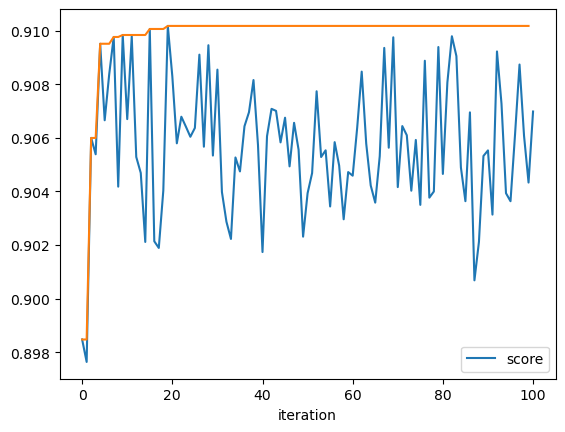

In [8]:
n = summary[['score', 'iteration']].groupby('iteration').max().plot()
best = [max(summary[summary['iteration']<=i]['score']) for i in range(100)]
p = plt.plot(best)

In [9]:
session.y_best

0.8345688283443451

In [10]:
summary

,iteration,score,hparameters,qEi
0,0,0.823602,"(68, 119, 90)",-1.000000
1,0,0.826415,"(70, 125, 65)",-1.000000
2,0,0.829627,"(79, 83, 118)",-1.000000
3,0,0.833508,"(69, 92, 127)",-1.000000
4,1,0.791471,"(64, 127, 121)",0.997644
5,1,0.824647,"(76, 91, 84)",0.997644
6,1,0.807356,"(113, 107, 123)",0.997644
7,1,0.804618,"(69, 80, 107)",0.997644
8,2,0.819714,"(67, 68, 81)",0.830046
9,2,0.834569,"(69, 123, 126)",0.830046
